In [213]:
import numpy as np
import matplotlib.pyplot as plt

In [133]:
# Number of experiments to run
n_experiments = 100

# The set of class labels in the sample
labels = ['healthy','ring','troph','schizont']
n_labels = len(labels)

# Define confusion matrix. Rows are ground truth, columns are output. Confusion matrix in this form
# is normalized such that all rows sum to 1 and is indexed in the same order as the 'labels' variable

cm = np.array([[0.97, 0.02, 0.01, 0.0], \
               [0.02, 0.97, 0.01, 0.0], \
               [0.01, 0.01, 0.97, 0.01], \
               [0.0, 0.01, 0.02, 0.97]])

# Ground truth sample composition (sums to 1)
sample_comp = np.array([1, 0.0002, 0.0001, 0.0001])
sample_comp[0] = 1 - np.sum(sample_comp[1:])
assert np.sum(sample_comp) == 1.0


[[0.97 0.02 0.01 0.  ]
 [0.02 0.97 0.01 0.  ]
 [0.01 0.01 0.97 0.01]
 [0.   0.01 0.02 0.97]]


In [134]:
# Define the duration of the imaging experiment, in seconds
t_max_s = 20*60

# Inference time per image. Assume for the moment we're limited by inference time
t_inf_s = 0.03

# Total images processed
n_images = t_max_s/t_inf_s

# Average number of cells per image
n_cells_per_image = 20

# Total cells imaged
n_cells_total = int(n_cells_per_image*n_images)
print(n_cells_total)

800000


In [135]:
# numpy random number generator
rng = np.random.default_rng()

# Ground truth class counts for each experiment
sample_gt = np.zeros((n_experiments, n_labels))

# Classifier's estimate of the sample
est = np.zeros((n_experiments, n_labels))
est_parasitemia = np.zeros((n_experiments, n_labels))

for e in range(n_experiments):
    
    r = rng.random(n_cells_total)
    # Create a random variable with length equal to the total number of cells
    
    # Partition
    p = 0.0
    
    # Partition the class counts in proportion to the random number distribution between 0-1
    for i in range(n_labels):
        sample_gt[e,i] = np.count_nonzero( np.logical_and(np.greater(r,p),np.less(r, np.sum(sample_comp[0:(i+1)]))))
        p += sample_comp[i]
    
    # Compute the sample estimates based on the confusion matrix
    est[e,:] = np.matmul(cm,sample_gt[e])

    # Sample composition estimate (parasitemia)
    est_parasitemia[e,:] = 100*est[e,:]/np.sum(est[e, :])
# Average over experiments
# Total number of parasites in sample
sample_gt_mean = np.average(sample_gt,0)
mean_est_parasitemia = np.average(est_parasitemia, 0)
std_est_parasitemia = np.std(est_parasitemia, 0)
absolute_parasitemia_error = mean_est_parasitemia - 100*sample_comp
fold_error = np.divide(absolute_parasitemia_error, 100*sample_comp)

# Make dicts for easier association with labels
sample_gt_dict = dict(zip(labels, sample_gt_mean))
abs_error_dict = dict(zip(labels,absolute_parasitemia_error))
fold_error_dict = dict(zip(labels,fold_error))
mean_dict = dict(zip(labels,mean_est_parasitemia))
gt_dict = dict(zip(labels, 100*sample_comp))
std_est_dict = dict(zip(labels, std_est_parasitemia))

In [136]:
print("\nAvg Healthy: {healthy:2.3f} \nAvg Ring: {ring:2.3f}\nAvg Troph: {troph:2.3f}\nAvg Schizont: {schizont:2.3f}".format(**sample_gt_dict))
print("\nGround truth composition: \nHealthy: {healthy:2.3f}% \nRing: {ring:2.3f}%\nTroph: {troph:2.3f}%\nSchizont: {schizont:2.3f}% ".format(**gt_dict))
print("\nMean of the estimates: \nHealthy: {healthy:2.3f}% \nRing: {ring:2.3f}%\nTroph: {troph:2.3f}%\nSchizont: {schizont:2.3f}% ".format(**mean_dict))
print("\nAbsolute error: \nHealthy: {healthy:2.3f}% \nRing: {ring:2.3f}%\nTroph: {troph:2.3f}%\nSchizont: {schizont:2.3f}% ".format(**abs_error_dict))
print("\nFold error: \nHealthy: {healthy:2.3f} \nRing: {ring:2.3f}\nTroph: {troph:2.3f}\nSchizont: {schizont:2.3f}".format(**fold_error_dict))
print("\nStdev across estimates: \nHealthy: {healthy:2.5f} \nRing: {ring:2.5f}\nTroph: {troph:2.5f}\nSchizont: {schizont:2.5f}".format(**std_est_dict))


Avg Healthy: 799680.960 
Avg Ring: 159.970
Avg Troph: 79.140
Avg Schizont: 79.930

Ground truth composition: 
Healthy: 99.960% 
Ring: 0.020%
Troph: 0.010%
Schizont: 0.010% 

Mean of the estimates: 
Healthy: 96.962% 
Ring: 2.019%
Troph: 1.009%
Schizont: 0.010% 

Absolute error: 
Healthy: -2.998% 
Ring: 1.999%
Troph: 0.999%
Schizont: 0.000% 

Fold error: 
Healthy: -0.030 
Ring: 99.935
Troph: 99.950
Schizont: 0.009

Stdev across estimates: 
Healthy: 0.00226 
Ring: 0.00160
Troph: 0.00090
Schizont: 0.00109


### Packaging the above
Package the above code into a single function `simulate`. 
This function can be called with a confusion matrix and a desired sample composition and will return the mean percentage estimates for each class (healthy, ring, troph, schizont). 

This function can be called repeatedly with different sample compositions to generate a titration curve. The helper function at the top, `proportions_from_parasitemia()` generates a sample composition with the desired total percentage of parasitemia. The relative proportions of ring/troph/schizont are based on the numbers given in the label-free malaria paper.

In [347]:
def proportions_from_parasitemia(parasitemia_perc):
    """Helper function to generate a sample composition with desired
    level of parasitemia.
    """
    
    # Use these numbers from the paper as a rough proportional factor between the parasitic stages
    r=3344
    t=1566 
    s=873
    
    m, n = t/r, s/r
    x = parasitemia_perc
    coeff = 1 / (1+m+n)
    proportions = [1 - x, x/coeff, x*m/coeff, x*n/coeff]
    return proportions

def simulate(cm, perc):
    # Number of experiments to run
    n_experiments = 100

    # The set of class labels in the sample
    labels = ['healthy','ring','troph','schizont']
    n_labels = len(labels)

    # Ground truth sample composition (sums to 1)
    sample_comp = np.array(perc)
    
    # Define the duration of the imaging experiment, in seconds
    t_max_s = 20*60

    # Inference time per image. Assume for the moment we're limited by inference time
    t_inf_s = 0.03

    # Total images processed
    n_images = t_max_s/t_inf_s

    # Average number of cells per image
    n_cells_per_image = 20

    # Total cells imaged
    n_cells_total = int(n_cells_per_image*n_images)
    
    # numpy random number generator
    rng = np.random.default_rng()

    # Ground truth class counts for each experiment
    sample_gt = np.zeros((n_experiments, n_labels))

    # Classifier's estimate of the sample
    est = np.zeros((n_experiments, n_labels))
    est_parasitemia = np.zeros((n_experiments, n_labels))

    for e in range(n_experiments):

        r = rng.random(n_cells_total)
        # Create a random variable with length equal to the total number of cells

        # Partition
        p = 0.0

        # Partition the class counts in proportion to the random number distribution between 0-1
        for i in range(n_labels):
            sample_gt[e,i] = np.count_nonzero( np.logical_and(np.greater(r,p),np.less(r, np.sum(sample_comp[0:(i+1)]))))
            p += sample_comp[i]

        # Compute the sample estimates based on the confusion matrix
        est[e,:] = np.matmul(sample_gt[e], cm)

        est_parasitemia[e,:] = 100*est[e,:]/np.sum(est[e, :])

    # Average over experiments
    # Total number of parasites in sample
    sample_gt_mean = np.average(sample_gt,0)
    mean_est_parasitemia = np.average(est_parasitemia, 0)
    std_est_parasitemia = np.std(est_parasitemia, 0)
    absolute_parasitemia_error = mean_est_parasitemia - 100*sample_comp
    fold_error = np.divide(absolute_parasitemia_error, 100*sample_comp)

    # Make dicts for easier association with labels
    sample_gt_dict = dict(zip(labels, sample_gt_mean))
    abs_error_dict = dict(zip(labels,absolute_parasitemia_error))
    fold_error_dict = dict(zip(labels,fold_error))
    mean_dict = dict(zip(labels,mean_est_parasitemia))
    gt_dict = dict(zip(labels, 100*sample_comp))
    std_est_dict = dict(zip(labels, std_est_parasitemia))

    return mean_dict

### Run the simulation at various titration points
- Runs the simulation for 10 titration points
- Generates a log-log plot overlaying the actual parasitemia vs. the estimated parasitemia by the network (based on the provided confusion matrix)

Raw counts given in CM, row-normalizing...
GT: 18.60% Est: 18.26%
GT: 9.30% Est: 9.40%
GT: 4.65% Est: 4.97%
GT: 2.33% Est: 2.75%
GT: 1.16% Est: 1.64%
GT: 0.58% Est: 1.09%
GT: 0.29% Est: 0.82%
GT: 0.15% Est: 0.68%
GT: 0.07% Est: 0.61%
GT: 0.04% Est: 0.57%


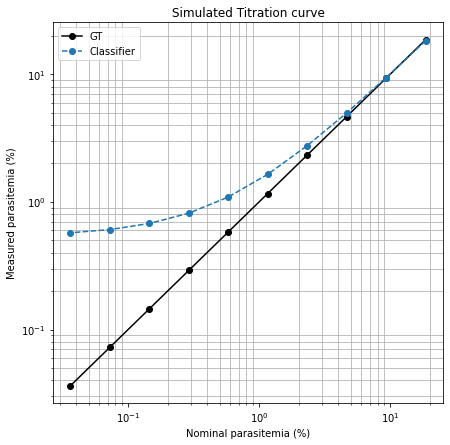

In [350]:
# The 'actual' parasitemia of the titration datasets
actual_parasitemia = [.186/2**x for x in range(0, 10)]
est_parasitemia = []

### EITHER provide the raw counts or the row-normalized matrix. 
### If the raw counts are provided, row-normalization will be done automatically.

# Rows are ground-truth (from top-to-bottom, healthy/ring/troph/schizont).
cm = np.array([
    [6288, 29, 5, 0], 
    [24, 524, 31, 0],
    [0, 26, 200, 26],
    [0, 0, 15, 50]])

# Row-normalize the confusion matrix if not already
if not np.all(np.sum(cm / np.sum(cm, axis=1)[:, np.newaxis], axis=1) == 1.0):
    print("Raw counts given in CM, row-normalizing...")
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]

# Run the simulation at each parasitemia point    
for perc in actual_parasitemia:
    results = simulate(cm, proportions_from_parasitemia(perc)).values()
    parasitemia = np.sum(list(results)[1:])
    print(f"GT: {100*perc:.2f}% Est: {parasitemia:.2f}%")
    est_parasitemia.append(parasitemia)

# Plot a log-log plot    
plt.figure(figsize=(7, 7))
actual_parasitemia = [x*100 for x in actual_parasitemia]
plt.loglog(actual_parasitemia, actual_parasitemia, linestyle='-', color='black', marker='o', label='GT')
plt.loglog(actual_parasitemia, est_parasitemia, linestyle='--', marker='o', label='Classifier')
plt.legend()
plt.title("Simulated Titration curve")
plt.xlabel("Nominal parasitemia (%)")
plt.ylabel("Measured parasitemia (%)")
plt.grid(b=True, which='minor')